# Lab 3 — dimensionality reduction

In [65]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle

from operator import itemgetter

%matplotlib inline
plt.style.use("ggplot")

In [66]:
from bokeh.plotting import figure, output_file, show

movies -> movieId, title, [genre]
tags -> tagId, tag
scores -> (movieId, tagId), relevance

In [4]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
scores = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)
ratings = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

In [5]:
tags_local = tags.collect()

In [ ]:
# print('Number of movies:', movies.count())
# print('Number of tags:', tags.count())
# print('Number of scores:', scores.count())
# print('Number of ratings:', ratings.count())

Construct MxN matrix, where N=1128 - tagId, M=10381 - movieId with at least one tag

In [7]:
sorted_scores = scores.map(lambda x: (x['movieId'], (x['tagId'], x['relevance']))).groupByKey().sortByKey()

M:

In [8]:
matrix = np.zeros((tags.count(), sorted_scores.count()))

In [9]:
matrix.shape

(1128, 10381)

In [10]:
s = sorted_scores.collect()

In [11]:
for i in range(len(s)):
    for j,r in s[i][1]:
        matrix[j-1][i] = r

In [12]:
print(matrix)

[[ 0.025    0.03975  0.0435  ...,  0.042    0.05975  0.05325]
 [ 0.025    0.04375  0.05475 ...,  0.03175  0.10375  0.08625]
 [ 0.05775  0.03775  0.028   ...,  0.017    0.1785   0.017  ]
 ..., 
 [ 0.03625  0.01475  0.0195  ...,  0.0095   0.51925  0.01575]
 [ 0.07775  0.09025  0.097   ...,  0.0755   0.067    0.1145 ]
 [ 0.023    0.01875  0.0185  ...,  0.01625  0.01725  0.02175]]


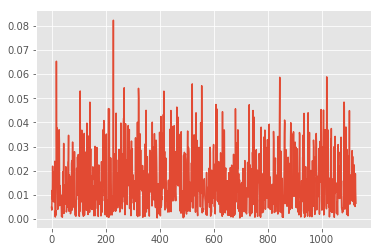

In [13]:
plt.plot(np.var(matrix, axis=1))

In [14]:
matrixCov = np.cov(matrix)
matrixCov.shape

(1128, 1128)

In [29]:
w, v = np.linalg.eigh(matrixCov)
# help(np.linalg.eigh)

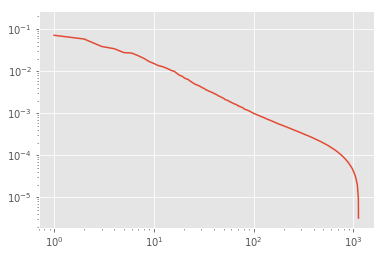

In [16]:
w_p = w.real.tolist()
w_p.reverse()
w_p /= w.real.sum()
plt.loglog(w_p)

Dimensionality reduction aims at explaining data by looking only at parts of it. To accurately classify the data, we need to look at the relations that give us the most information. In this case, the importance of relations is given in the eigenvalues of the covariance matrix. 

In [17]:
w_c = np.cumsum(w_p)
print('Principal components to capture 2/3:', len(w_c[w_c <= 2/3])+1)

Principal components to capture 2/3: 37


In [18]:
top_eigvecs = v[:-6:-1]

## 3.2 Concept Space

In [45]:
print("Top Eigenvectors length", len(top_eigvecs))
i = 0
for vec in top_eigvecs:
    print(len(vec))
    print(vec[i], tags_local[i])

Top Eigenvectors length 5
1128
0.000593969720919 {'tagId': 1, 'tag': '007'}
1128
-0.0022866200602 {'tagId': 1, 'tag': '007'}
1128
0.000935658210135 {'tagId': 1, 'tag': '007'}
1128
0.00381772624866 {'tagId': 1, 'tag': '007'}
1128
0.00427381072868 {'tagId': 1, 'tag': '007'}


In [34]:
# for vec in top_eigvecs:
print(top_eigvecs[0], len(top_eigvecs[0]))

[ 0.00059397 -0.01100711 -0.00067457 ..., -0.01634403 -0.00551606
 -0.00137267] 1128


In [19]:
k = 1
for vec in top_eigvecs:
    print('Eigenvector', k)
    ix = np.argsort(vec)
    print('Top tags')
    for i in ix[:10]:
        print(tags_local[i+1]['tag'], end=', ')
    print('\nLow tags')
    for i in ix[:-11:-1]:
        print(tags_local[i+1]['tag'], end=', ')
    print('\n')
    k += 1

Eigenvector 1
Top tags
art house, bad ending, atmospheric, bad acting, suspense, arnold, artificial intelligence, snakes, business, spaghetti western, 
Low tags
atheism, based on a play, bad, awesome soundtrack, propaganda, san francisco, best of 2005, caper, beautiful, author:neil gaiman, 

Eigenvector 2
Top tags
atheism, bad, based on a play, awesome soundtrack, author:neil gaiman, beautiful, australia, circus, best of 2005, based on a book, 
Low tags
art house, bad ending, atmospheric, bad acting, author:alan moore, arnold, assassins, argentina, artificial intelligence, boring!, 

Eigenvector 3
Top tags
assassination, astronauts, bad cgi, bad script, autism, ballet, based on a video game, assassins, wilderness, based on comic, 
Low tags
bad ending, bad acting, bad science, australian, atmospheric, awesome soundtrack, awesome, author:alan moore, wedding, artistic, 

Eigenvector 4
Top tags
colourful, chicago, depressing, cool, entertaining, fun movie, computer animation, computer game

In [85]:
dictionary = {}
for i in range(len(top_eigvecs[0])):
    dirs = []
    for vec in top_eigvecs:
        dirs.append(vec[i])
    dictionary[tags_local[i]['tag']] = dirs

In [93]:
tagID_princ_coord = {}
for i in range(len(top_eigvecs[0])):
    dirs = []
    for vec in top_eigvecs:
        dirs.append(vec[i])
    tagID_princ_coord[tags_local[i]['tagId']] = dirs

In [64]:
filename = 'arrrrr.txt'
filepickle = 'arrrrr.pickle'
# with open(filename, 'w') as file:
#     file.write(json.dumps(dict))
    
pickle.dump(dictionary, open(filepickle, 'wb'))

## 3.3 Movie visualization

In [70]:
with open('selected-movies.pickle', 'rb') as handle:
    selection = pickle.load(handle, encoding='utf-8') # encoding='latin1'

In [73]:
selection[:5]

((780, 'Independence Day (a.k.a. ID4) (1996)', 0.6),
 (5349, 'Spider-Man (2002)', 0.89),
 (2571, 'Matrix, The (1999)', 0.87),
 (318, 'Shawshank Redemption, The (1994)', 0.91),
 (2329, 'American History X (1998)', 0.83))

In [91]:
x = []
y = []
rating = []

for movie in selection:
    print(movie[0])
#     print(tagID_princ_coord)
    principal_coord = tagID_princ_coord[movie[0]]
    print(principal_coord)
    x.append(principal_coord[0])
    y.append(principal_coord[1])
    rating.append(movie[2])

780
[-0.018660264882695798, -0.0274954834277257, -0.0032538577870359011, 0.017814509421962558, -0.025798888762439527]
5349


KeyError: 5349